In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from superimposed import Superimposed

# Loading Data

The output of torchvision datasets are PILImage images of range [0, 1].

We transform them to Tensors of normalized range [-1, 1].

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = Superimposed('./mnist_data', './cifar_data', train=True,
                                        download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = Superimposed('./mnist_data', './cifar_data', train=False,
                                        download=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
task0_classes = ["animal", "non-animal"]
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
default_classes = [cifar_classes[i//10] + "-" + mnist_classes[i%10] for i in range(100)]
task1_classes = ["below-5", "above-equal-5"]

In [6]:
def label_to_default_task(l):
    return int(str(int(l[0])) + str(int(l[1])))

def label_to_cifar(l):
    return int(l[0])

#animal vs non-animal
def label_to_task0(l):
    if len(l.shape) != 0:
        l = label_to_default_task(l)
    if l//10 in [2, 3, 4, 5, 6, 7]: #animal
        return 0
    elif l//10 in [0, 1, 8, 9]: #not animal
        return 1
    else:
        return 2

#task1 is large vs small mamall
def label_to_task1(l):
    if len(l.shape) != 0:
        l = label_to_default_task(l)
    if l%10 < 5:
        return 0
    else:
        return 1

## Training Data Samples

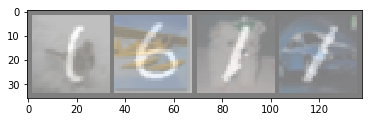

animal non-animal animal non-animal
below-5 above-equal-5 below-5 below-5


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % task0_classes[label_to_task0(labels[j])] for j in range(4)))
print(' '.join('%5s' % task1_classes[label_to_task1(labels[j])] for j in range(4)))


# Defining the Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
        self.fc1_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2_1 = nn.Linear(120, 84)
        self.fc3_1 = nn.Linear(84, 2)

    def forward(self, x):
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x1 = x.view(-1, 16 * 5 * 5)
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        
        x2 = x.view(-1, 16 * 5 * 5)
        x2 = F.relu(self.fc1_1(x2))
        x2 = F.relu(self.fc2_1(x2))
        x2 = self.fc3_1(x2)
        """
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x1 = self.fc3(x)
        
        x2 = self.fc3_1(x)
        return x1, x2


net = Net()

## Defining the Loss function and Optimizer

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the Network

In [11]:
def train(net, optimizer, criterion, epochs=1):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            labels1 = torch.tensor([label_to_task0(l) for l in labels])
            labels2 = torch.tensor([label_to_task1(l) for l in labels])
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs1, _ = net(inputs)
            loss1 = criterion(outputs1, labels1)
            loss1.backward()
            optimizer.step()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            _, outputs2 = net(inputs)
            loss2 = criterion(outputs2, labels2)
            loss2.backward()
            optimizer.step()

            # print statistics
            running_loss += loss1.item() + loss2.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

In [12]:
train(net, optimizer, criterion)

[1,  2000] loss: 1.331
[1,  4000] loss: 0.962
[1,  6000] loss: 0.743
[1,  8000] loss: 0.648
[1, 10000] loss: 0.597
[1, 12000] loss: 0.540
Finished Training


# Testing the Network

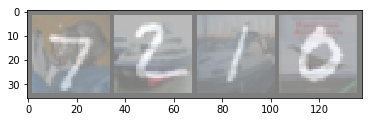

GroundTruth:  animal non-animal non-animal non-animal
GroundTruth:  above-equal-5 below-5 below-5 below-5


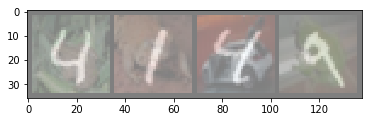

GroundTruth:  animal animal non-animal animal
GroundTruth:  below-5 below-5 below-5 above-equal-5


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images2, labels2 = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % task0_classes[label_to_task0(labels[j])] for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % task1_classes[label_to_task1(labels[j])] for j in range(4)))
# print images
imshow(torchvision.utils.make_grid(images2))
print('GroundTruth: ', ' '.join('%5s' % task0_classes[label_to_task0(labels2[j])] for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % task1_classes[label_to_task1(labels2[j])] for j in range(4)))

In [14]:
outputs1, outputs2 = net(images)

_, predicted = torch.max(outputs1, 1)
print('Predicted: ', ' '.join('%5s' % task0_classes[predicted[j]]
                              for j in range(4)))

_, predicted = torch.max(outputs2, 1)
print('Predicted: ', ' '.join('%5s' % task1_classes[predicted[j]]
                              for j in range(4)))

outputs1, outputs2 = net(images2)
_, predicted = torch.max(outputs1, 1)
print('Predicted: ', ' '.join('%5s' % task0_classes[predicted[j]]
                              for j in range(4)))

_, predicted = torch.max(outputs2, 1)
print('Predicted: ', ' '.join('%5s' % task1_classes[predicted[j]]
                              for j in range(4)))

Predicted:  animal non-animal non-animal non-animal
Predicted:  above-equal-5 below-5 below-5 below-5
Predicted:  animal animal animal animal
Predicted:  below-5 below-5 below-5 above-equal-5


In [15]:
def test_overall(net, performance=None):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels = torch.tensor([label_to_task0(l) for l in labels])
            outputs, _ = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    if performance != None:
        performance["all"].append(100 * correct / total)

In [16]:
test_overall(net)

Accuracy of the network on the 10000 test images: 83 %


In [17]:
def test_individual(net, performance=None):
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels = torch.tensor([label_to_task0(l) for l in labels])
            outputs, _ = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(2):
        if class_total[i] == 0:
            if performance != None:
                performance[task0_classes[i]].append(None)
        else:
            print('Accuracy of %5s : %2d %%' % (
                task0_classes[i], 100 * class_correct[i] / class_total[i]))
            if performance != None:
                performance[task0_classes[i]].append(100 * class_correct[i] / class_total[i])

In [18]:
test_individual(net)

Accuracy of animal : 85 %
Accuracy of non-animal : 80 %


In [20]:
def get_performance_data(iterations):
    performance = {'all':[]}
    for c in task0_classes:
            performance[c] = []
    for _ in range(iterations):
        net = Net()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        
        train(net, optimizer, criterion)
        test_overall(net, performance)
        test_individual(net, performance)
        
    return performance
        
performance = get_performance_data(10)

[1,  2000] loss: 1.370
[1,  4000] loss: 1.291
[1,  6000] loss: 0.889
[1,  8000] loss: 0.702
[1, 10000] loss: 0.640
[1, 12000] loss: 0.602
Finished Training
Accuracy of the network on the 10000 test images: 81 %
Accuracy of animal : 87 %
Accuracy of non-animal : 71 %
[1,  2000] loss: 1.311
[1,  4000] loss: 0.941
[1,  6000] loss: 0.713
[1,  8000] loss: 0.618
[1, 10000] loss: 0.570
[1, 12000] loss: 0.528
Finished Training
Accuracy of the network on the 10000 test images: 82 %
Accuracy of animal : 91 %
Accuracy of non-animal : 68 %
[1,  2000] loss: 1.311
[1,  4000] loss: 0.917
[1,  6000] loss: 0.696
[1,  8000] loss: 0.615
[1, 10000] loss: 0.569
[1, 12000] loss: 0.533
Finished Training
Accuracy of the network on the 10000 test images: 83 %
Accuracy of animal : 88 %
Accuracy of non-animal : 75 %
[1,  2000] loss: 1.303
[1,  4000] loss: 0.866
[1,  6000] loss: 0.693
[1,  8000] loss: 0.612
[1, 10000] loss: 0.576
[1, 12000] loss: 0.539
Finished Training
Accuracy of the network on the 10000 test i

In [21]:
df = pd.DataFrame(data=performance)
df.to_csv('cifar_mnist_conflicting_performance.csv')

In [22]:
np.mean(performance['all'])

82.106